In [1]:
import os
import numpy as np
from scipy import integrate
import sys
sys.path.append('../../scripts/')

import matplotlib.pyplot as plt
import mpl_stylesheet
mpl_stylesheet.banskt_presentation(fontfamily = 'latex-clearsans', fontsize = 18, colors = 'banskt')

In [2]:
simdir = '12639_450_10_800_30_100_100_0.01_0.5_0.0_1.0_0.6_4.0_0.1_20_0.02'
srcdir = '/cbscratch/sbanerj/trans-eqtl/simulation'

ppopts = ['raw', 'cclm', 'cclasso', 'knn30', 'cclasso_knn30']
qnopts = [True, False]
methods = ['tejaas_rr', 'tejaas_jpa', 'matrixeqtl']

method_details = {'tejaas_rr': 'tejaas_permnull_sb0.2',
                  'tejaas_jpa': 'jpa',
                  'matrixeqtl': 'matrixeqtl'}

rocfiledict = dict()
pplist = list()
for method in methods:
    rocfiledict[method] = dict()
    for ppopt in ppopts:
        for qnopt in qnopts:
            ppname = f"{ppopt};with_qn" if qnopt else f"{ppopt};without_qn"
            if ppname not in pplist:
                pplist.append(ppname)
            
            if qnopt:
                prcc = f"qn_{ppopt}" if ppopt != "raw" else "qn"
            else:
                prcc = f"{ppopt}"
                
            ## Special modifier for KNN on raw data for Tejaas.
            if ppopt.startswith("knn") and not qnopt and method != "matrixeqtl": prcc = f"raw_{ppopt}"
            rocfile = f"{method_details[method]}_{prcc}_peer0"
            rocfiledict[method][ppname] = rocfile

In [11]:
include_ppopts = ['raw', 'cclm', 'knn30', 'cclasso']

#### AUC where FPR < 0.1
fprcut = 0.1
xmax = 0.1
xshift = 0.0
xmajorticks = [0.0, 0.05, 0.1]
xminorticks = [0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1]
data_csv_file = "simulation_preproc_auc01_comparison.txt"
plot_out_file = "../plots/simulation_preproc_auc01_comparison.png"

#### Full AUC
# fprcut = 1.0
# xmax = 1.0
# xshift = 0.5
# xmajorticks = [0.6, 0.8, 1.0]
# xminorticks = [0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
# data_csv_file = "simulation_preproc_auc_comparison.txt"
# plot_out_file = "../plots/simulation_preproc_auc_comparison.png"

methodcolors = {'tejaas_rr':  '#cc3129ff',
                'tejaas_jpa': '#ff8680ff',
                'matrixeqtl': '#209E2FFF',
                'matrixeqtl_fdr': '#1fcc80ff'}

methodlabels = {'tejaas_rr': 'RevReg',
                'tejaas_jpa': 'JPA',
                'matrixeqtl': 'MatrixEQTL'}

In [12]:
data  = dict()
errup = dict()
errdn = dict()
for method in methods:
    data[method]  = dict()
    errup[method] = dict()
    errdn[method] = dict()
    for ppkey in pplist:
        data[method][ppkey]  = dict()
        errup[method][ppkey] = dict()
        errdn[method][ppkey] = dict()
        rocfile = os.path.join(srcdir, simdir, f'rocdata/{rocfiledict[method][ppkey]}_fpr_tpr.txt')
        success = False
        if os.path.exists(rocfile):
            roc = np.loadtxt(rocfile, skiprows=1)
            xx = roc[:, 0]
            yy = roc[:, 1]
            ystd = roc[:, 2]
            idx = np.where(xx <= fprcut)[0]
            if idx.shape[0] > 5:
                auc = integrate.simps(yy[idx], xx[idx])
                aucup = integrate.simps(yy[idx] + ystd[idx], xx[idx])
                aucdn = integrate.simps(yy[idx] - ystd[idx], xx[idx])
                data[method][ppkey]  = auc
                errup[method][ppkey] = aucup
                errdn[method][ppkey] = aucdn
                success = True
        if not success:
            yrand = np.linspace(0, fprcut, 100)
            auc = integrate.simps(yrand, yrand)
            data[method][ppkey]  = auc
            errup[method][ppkey] = auc
            errdn[method][ppkey] = auc

In [13]:
import pandas as pd
        
colnames = methods + [f'{x}_errup' for x in methods] + [f'{x}_errdn' for x in methods]

datadf = pd.DataFrame(index=pplist, columns=colnames)
for fn in datadf.index:
    fndata = [data[x][fn] for x in methods] + \
             [errup[x][fn] for x in methods] + \
             [errdn[x][fn] for x in methods]
    datadf.loc[fn] = fndata
    
datadf.to_csv(data_csv_file)
datadf

,tejaas_rr,tejaas_jpa,matrixeqtl,tejaas_rr_errup,tejaas_jpa_errup,matrixeqtl_errup,tejaas_rr_errdn,tejaas_jpa_errdn,matrixeqtl_errdn
raw;with_qn,0.0188219,0.00560743,0.00600995,0.0243074,0.00847971,0.00935063,0.0133364,0.00273515,0.00266926
raw;without_qn,0.0541693,0.00545904,0.00562798,0.0612963,0.00764718,0.00911111,0.0470423,0.0032709,0.00214486
cclm;with_qn,0.00495365,0.0162999,0.0458111,0.00867388,0.0223354,0.0535023,0.00123343,0.0102643,0.03812
cclm;without_qn,0.0164889,0.0730467,0.0700024,0.0230553,0.0799591,0.0777953,0.00992254,0.0661344,0.0622095
cclasso;with_qn,0.0231727,0.00871218,0.026788,0.0290169,0.0136265,0.0346053,0.0173285,0.00379783,0.0189707
cclasso;without_qn,0.0962511,0.0748033,0.0699371,0.0986013,0.0823028,0.0781637,0.093901,0.0673039,0.0617104
knn30;with_qn,0.0362971,0.0187057,0.0155968,0.0438379,0.0250377,0.0218232,0.0287563,0.0123736,0.00937035
knn30;without_qn,0.0935605,0.00613642,0.0109584,0.0973755,0.00968574,0.0166939,0.0897455,0.0025871,0.00522282
cclasso_knn30;with_qn,0.0322692,0.0370821,0.0407442,0.0390092,0.0465414,0.0483328,0.0255291,0.0276229,0.0331556
cclasso_knn30;without_qn,0.096479,0.0884473,0.0751245,0.0988148,0.0932338,0.0819545,0.0941433,0.0836608,0.0682946


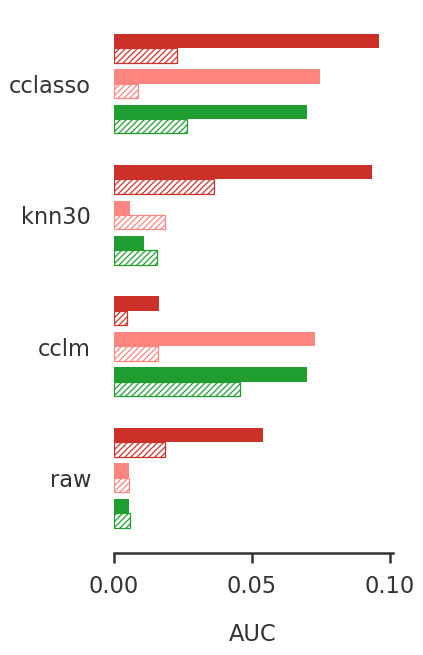

In [14]:
fig = plt.figure(figsize = (4, 8))
ax1 = fig.add_subplot(111)

barh  = 0.22
barsep = 0.1

ccidx = np.arange(len(include_ppopts)) * 2
for i, method in enumerate(methods):
    raw_idxlist = [f'{x};without_qn' for x in include_ppopts]
    qn_idxlist  = [f'{x};with_qn' for x in include_ppopts]
    color = methodcolors[method]
    #rawvals = [x - xshift for x in list(datadf[method][raw_idxlist])]
    rawvals = [x - xshift for x in datadf.loc[raw_idxlist, method].tolist()]
    qnvals  = [x - xshift for x in list(datadf[method][qn_idxlist])]
    
    ypositions = ccidx - (i * barh * 2) - (i * barsep)
    rects = ax1.barh(ypositions, rawvals, barh, color = color, edgecolor = color, lw = 0 )
    
    ypositions = ccidx - barh - (i * barh * 2) - (i * barsep)
    rects = ax1.barh(ypositions, qnvals, barh, color = 'w', edgecolor = color )
    for bar_rect in rects:
        bar_rect.set_hatch('/////')


ax1.tick_params(bottom = True, top = False, left = False, right = False, 
               labelleft = True, labelbottom = True, labeltop = False)
    
relative_ypos = - 0.5 * (2 * len(methods) * barh + (len(methods) - 1) * barsep)
mtickpos = ccidx + relative_ypos + barh / 2
ax1.set_yticks(mtickpos)
ax1.set_yticklabels(include_ppopts)

# #ax1.tick_params(bottom = True, labelbottom = True)
ax1.set_xticks([x - xshift for x in xmajorticks])
xticklabels = ['{:04.2f}'.format(x) for x in xmajorticks]
ax1.set_xticklabels(xticklabels)

for side, border in ax1.spines.items():
    border.set_visible(False)
    if side == 'bottom':
        border.set_visible(True)
        
ax1.set_xlabel('AUC')
plt.savefig(plot_out_file, bbox_inches='tight')
plt.show()